# Parcours de Graphes

<span style="color:red">Honteusement pompé sur le cours de Paul Mangold</span>

L'idée derrière le parcours de graphe est de trouver des chemins entre des sommets.
En fonction du but de la recherche de chemin, différents algorithmes sont utilisés.

Par exemple, pour trouver le plus court chemin entre deux sommets d'un graphe, on fera souvent un parcours en largeur du graphe.

Le but de ce TP est d'explorer plusieurs façons de trouver des chemins dans un graphe, en voyant comment trouver un chemin optimal dans un graphe, puis dans un graphe pondéré et enfin, comment on peut essayer d'améliorer l'exécution de notre algorithme.

In [4]:
from random import randint, seed

**Activité** Le module [timeit](https://docs.python.org/fr/3/library/timeit.html) de python permet de mesurer les temps d'exécution. Dans ipython et donc dans les notebooks, cette fonctionnalité est accessible via le raccourci 

     %timeit
     
Comparer aussi les temps d'exécution d'appartenance dans une liste et dans un ensemble. 

In [2]:
n=100000
liste = [randint(0,100) for i in range(n)]
ens = set(liste)

In [3]:
%timeit 5 in liste

1 µs ± 5.86 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [4]:
%timeit 5 in ens

36.1 ns ± 0.0526 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


## Structures de Données

Pour effectuer un parcours en largeur efficace, on a besoin d'une structure de données particulière : une file.

Une file est une liste d'éléments qui permet :

* de rajouter des éléments à la fin en temps constant ;
* de récupérer le premier élément en temps constant.

On appelle ça une méthode FIFO, pour "First In, First Out", ou PEPS en français ("Premier Entré, Premier Sorti").
C'est donc adapté au parcours en largeur : on rajoute les sommets du graphe dans l'ordre où on les rencontre, puis on les visite dans cet ordre là également.

En `Python`, on peut utiliser l'objet `deque` (pour "double-ended queue).
Voilà quelques exemples d'ajout et de retrait d'éléments dans un `deque` :

In [5]:
from collections import deque

In [6]:
# initialisation d'un deque
d = deque([1,2,3])
print("Valeur initiale :", d, "\n")

# ajout d'un élément à la fin 
d.append(4)
print("Valeur après ajout du 4 :", d, "\n")

# retrait du premier élément
a = d.popleft()
print("Élément retiré :", a)
print("Nouvelle valeur de deque :", d)

Valeur initiale : deque([1, 2, 3]) 

Valeur après ajout du 4 : deque([1, 2, 3, 4]) 

Élément retiré : 1
Nouvelle valeur de deque : deque([2, 3, 4])


**Question** Pour apprécier la différence en exécution dans python faire la fonction suivante avec une liste puis avec une deque.


    def test(n=100000, graine=0):
      seed(graine)  # initier le générateur aléatoire avec la graine
      # initialiser la liste avec un unique élément 0
      # répéter n fois 
      #   tirer un nombre aléatoire entre 0 et 2
      #   si la valeur tirée est le premier élément de la liste alors l'enlever
      #   sinon l'ajouter en fin de liste
      # retourner la liste
    
Tester avec n = 10, les deux fonctions (test_list, et test_deque). Elles doivent renvoyer la même chose.

In [7]:
def test_list(n=10, graine=0):
    seed(graine)
    d = [0]
    for i in range(n):
        t = randint(0,2)
        if t == d[0]:
            d.pop(0)
        else :
            d.append(t)
    return d

In [8]:
def test_deque(n=10, graine=0):
    seed(graine)
    d = deque([0])
    for i in range(n):
        t = randint(0,2)
        if t == d[0]:
            d.popleft()
        else :
            d.append(t)
    return liste(d)

In [9]:
%timeit test_list()

12.6 µs ± 112 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
%timeit test_deque()

TypeError: 'list' object is not callable

**Question**   Constatez les différences de vitesse d'exécution avec timeit

In [ ]:
non

## Parcours en largeur

Maintenant qu'on sait comment faire une file, on est prêt-es pour parcourir un graphe en largeur.

On va utiliser la représentation des graphes par liste d'adjacence.
Pour cela, vous pouvez utiliser la fonction suivante, qui prend un graphe en entrée et qui renvoie les listes d'adjacence correspondantes :

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def liste_adjacence(G):
    adj = {}
    
    for sommet, adjacence in G.adjacency():
        adj[sommet] = list(adjacence.keys())
        
    return adj

**Question.** Voilà un graphe aléatoire, 

          G_aleatoire = nx.fast_gnp_random_graph(4, 0.4, seed=123)

afficher sa liste d'adjacence

In [8]:
G_aleatoire = nx.fast_gnp_random_graph(4, 0.4, seed=123)
print(liste_adjacence(G_aleatoire))

{0: [1, 2, 3], 1: [0, 3], 2: [0], 3: [0, 1]}


On va avoir besoin d'afficher des graphes, pour cela, vous pouvez utiliser la fonction `afficher_graphe` suivante.
Elle prend en argument un graphe `G` et un dictionnaire de couleurs, voilà un exemple de comment définir ce dictionnaire.

In [9]:
def afficher_graphe(G, couleurs=None):
    pos = nx.spring_layout(G, seed=42)
    
    if couleurs is None:
        couleurs = {s: "white" for s in G.nodes()}
    
    nx.draw(G, 
            pos,
            node_color=couleurs.values(), 
            edgecolors="black",
            with_labels=True,
            node_size=500)
    
    plt.show()

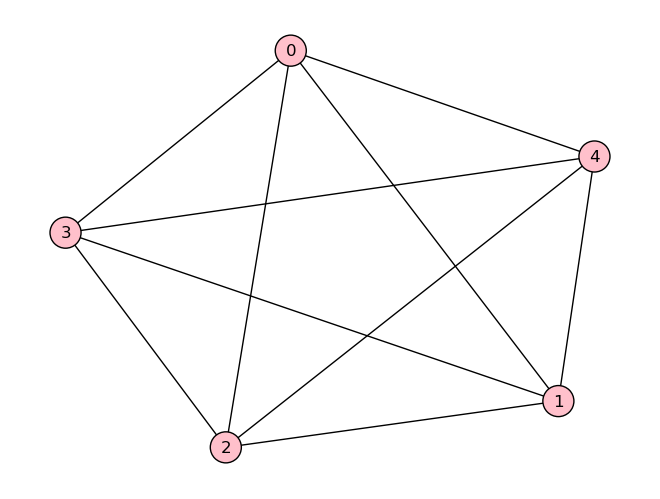

In [10]:
# par exemple   
G_complet = nx.complete_graph(5)
couleurs = {s: "pink" for s in G_complet.nodes()}
afficher_graphe(G_complet, couleurs)

Comme on l'a vu en cours, le principe du parcours en largeur consiste à garder en mémoire :

* une file `a_visiter` qui correspond aux éléments que l'on a repérés mais pas encore visités ;
* un ensemble `visites` qui correspond aux éléments que l'on a déjà visités ;
* un dictionnaire `predecesseur` qui indique, pour chaque sommet, quel sommet y a mené dans le parcours (cela va permettre de trouver le plus court chemin).

On pourra initialiser le dictionnaire prédecesseur à `predecesseur = {s: None}`, de façon à savoir qu'on est tombé-es sur le sommet initial car c'est le seul à avoir `None` comme prédecesseur.

Au début, `a_visiter` contient seulement le sommet duquel on part.
L'algorithme procède alors ainsi :

Tant que `a_visiter` n'est pas vide :
* tirer `s` dans la file (premier élément de la file) ;
* ajouter `s` à `visites` ;
* pour chaque sommet voisin `v` de `s` (donc dans `adj(s)`) :
    * si `v` est dans `visites` (on l'a déjà traité) ou dans `a_visiter` (on a déjà prévu de le traiter), l'ignorer ;
    * sinon, le rajouter dans `a_visiter`, et définir `predecesseur[v] = s`.

**Question.** Implémentez l'algorithme de parcours en largeur décrit ci-dessus. 

On définira une fonction `parcours_largeur` qui prend en argument un graphe, un sommet initial, et un argument `afficher`.

Si l'argument `afficher` vaut `True`, à chaque fois que vous explorez un nouvel sommet, vous afficherez le graphe avec, en couleur, les sommets que vous avez déjà explorés (pour cela, vous pouvez garder un dictionnaire `couleurs` que vous mettrez à jour au fur et à mesure).

In [11]:
def parcours_largeur(G, sommet_initial, afficher=False):
    s = sommet_initial
    a_visiter = deque([s])
    visite = []
    predecesseur = {s: None}
    adj = liste_adjacence(G)
    couleurs = {sommet: "pink" for sommet in G.nodes()}
    while len(a_visiter) != 0:
        s = a_visiter.popleft()
        visite.append(s)
        if afficher:
            couleurs[s] = "red"
            afficher_graphe(G, couleurs)
        for v in adj[s]:
            if not (v in visite or v in a_visiter):
                a_visiter.append(v)
                predecesseur[v] = s
    return predecesseur
            

Essayez votre fonction avec la ligne suivante. Il faut que la fonction affiche l'état du graphe à chacune des étapes de l'exécution de l'algorithme, et renvoie le dictionnaire `predecesseur` dont il est question au dessus.

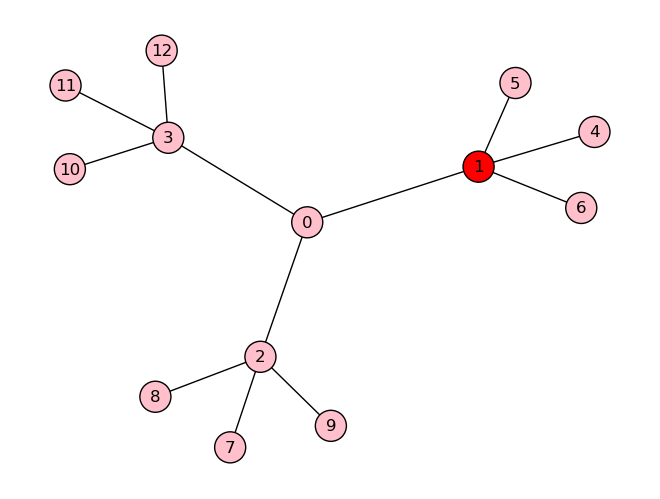

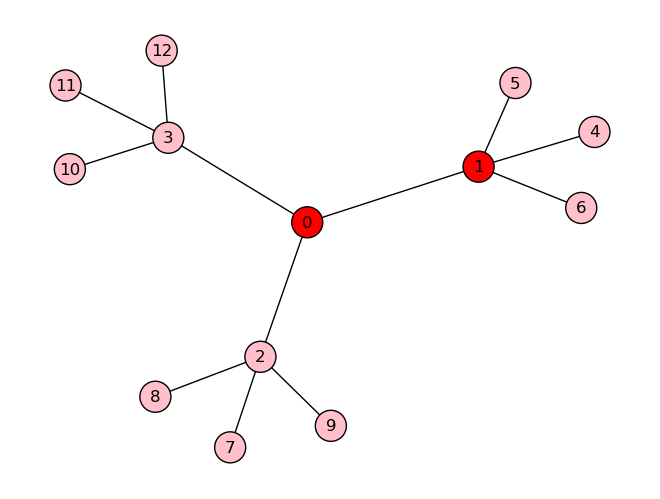

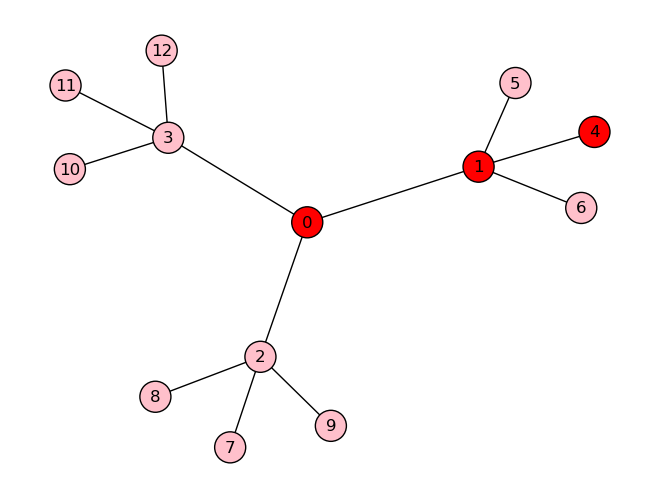

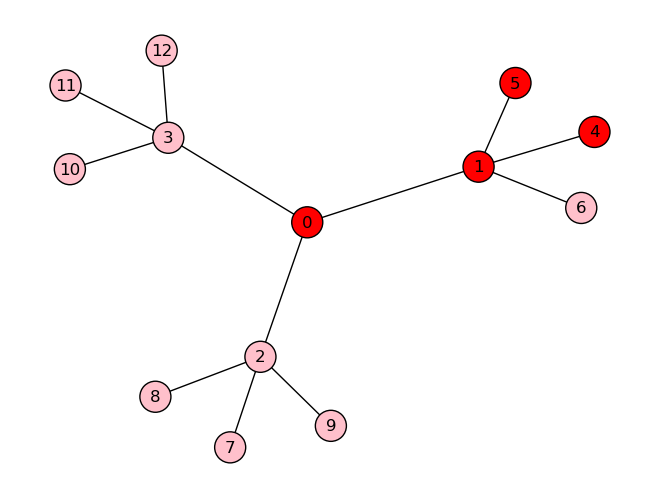

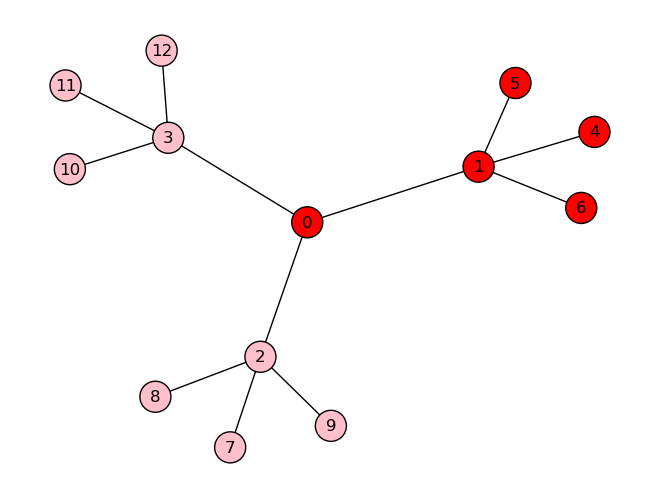

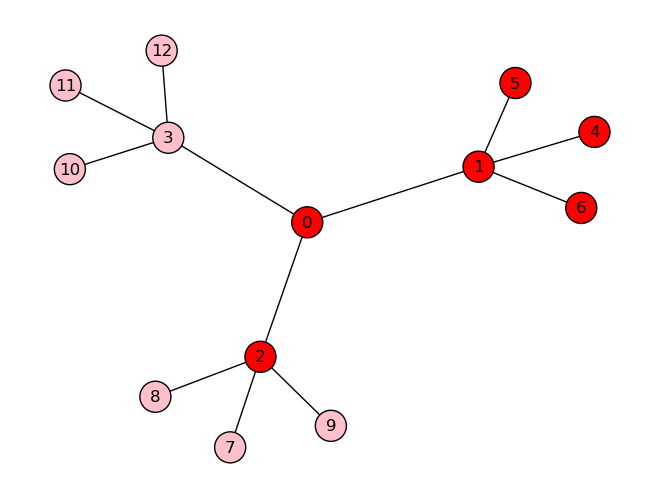

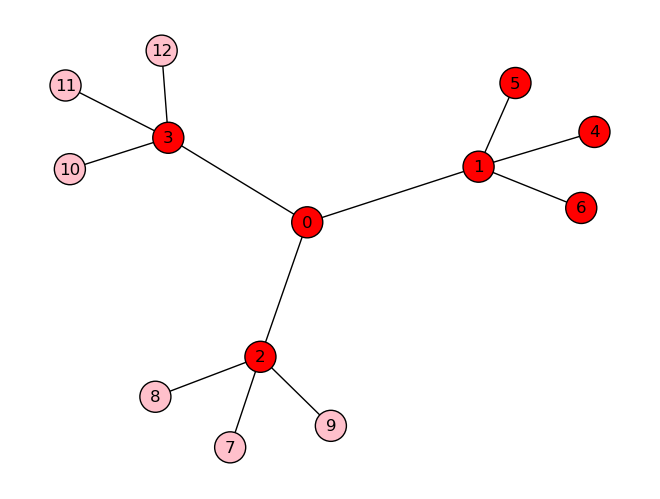

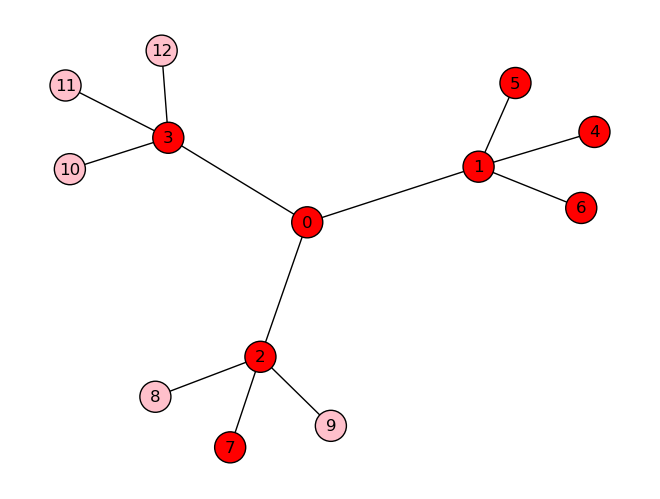

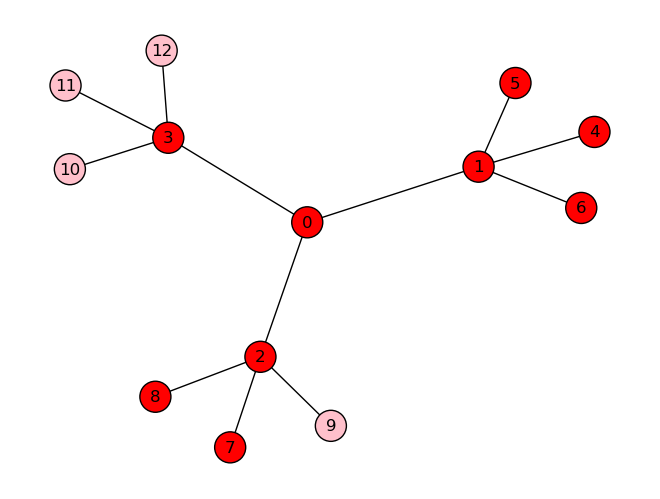

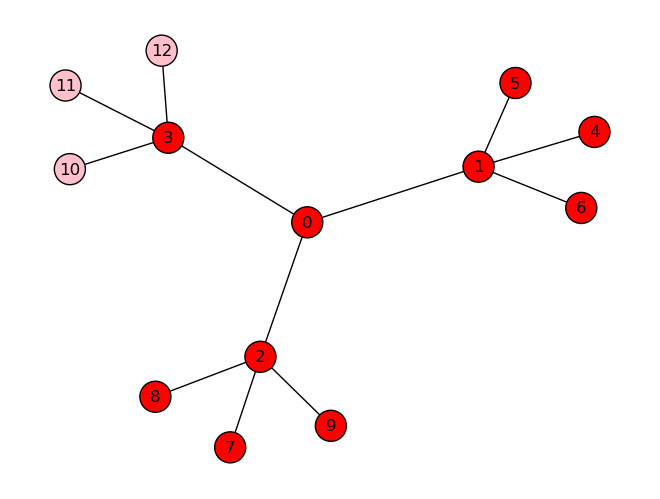

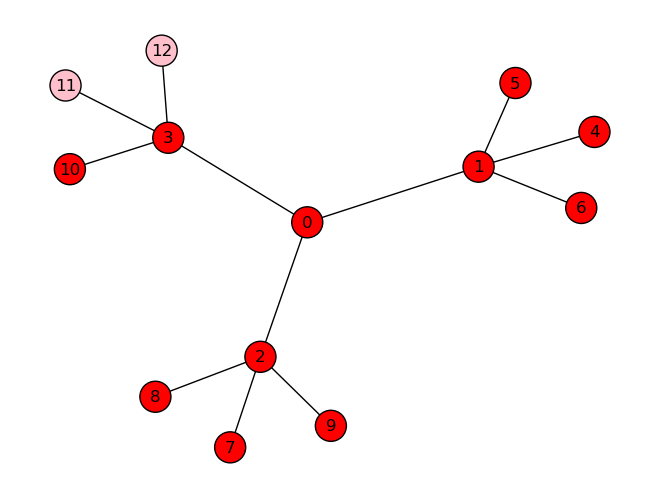

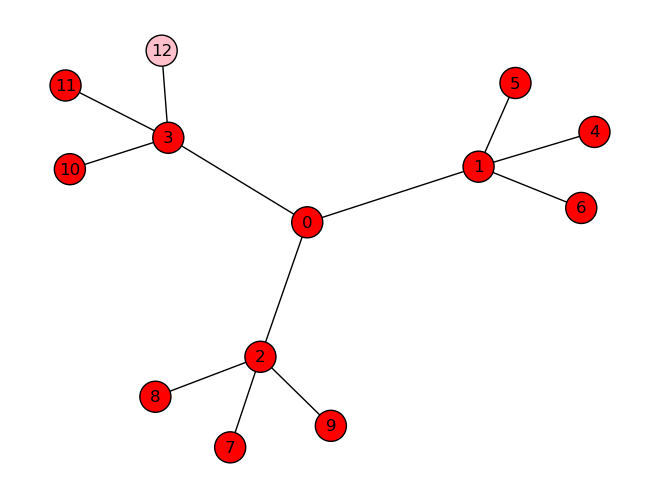

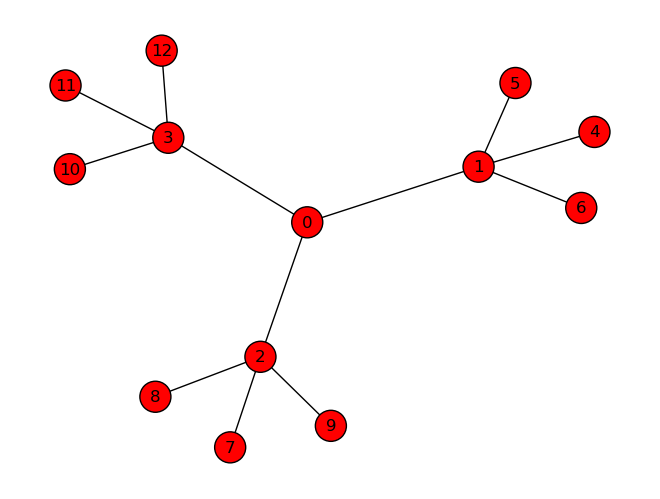

{1: None, 0: 1, 4: 1, 5: 1, 6: 1, 2: 0, 3: 0, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3}


In [17]:
# tester la fonction sur un graphe
predecesseur = parcours_largeur(nx.balanced_tree(3, 2), 1, afficher=True)
print(predecesseur)

**Question.** Quelle est la complexité de cet algorithme ?

exponantielle

## Chemin le plus court

Dans la fonction `parcours_largeur`, vous avez implémenté le parcours en largeur d'un graphe.
Au cours de ce parcours, on garde en mémoire un dictionnaire `predecesseur` tel que `predecesseur[v] = u` si le sommet `u` précède le sommet `v` dans le chemin entre le point de départ et `v`.

Dès lors, on peut trouver le chemin entre `s` et `v`.
En effet, `predecesseur[v]` contient l'avant dernier sommet du chemin entre `s` et `v`.
De même, `predecesseur[predecesseur[v]]` renvoie l'avant-avant dernier sommet de ce chemin.

En itérant jusqu'à tomber sur `s`, on a donc un chemin.

Ce chemin est en fait le plus court chemin de `s` à `v`.

**Question.** Pourquoi (informellement) est-ce que le chemin obtenu de cette manière est un chemin le plus court entre `s` et `v` ?

*Réponse* : 

**Question.** Implémenter une fonction `chemin(predecesseur, s, v)` qui, à partir du dictionnaire renvoyé par la fonction `parcours_largeur`, renvoie le chemin de `s` à `v`.

In [12]:
def chemin(predecesseur, s, v):
    chemin = [v]
    while predecesseur[predecesseur[v]] != s:
        chemin.append(predecesseur[v])
        predecesseur[v] = predecesseur[predecesseur[v]]
    chemin.append(predecesseur[v])
    chemin.append(s)
    return chemin

# def chemin(predecesseur, s , v):
#     sommet_courant = v
#     chemin = deque([v])
#     while predecesseur[sommet_courant] != s:


#     return chemin

Testez votre fonction avec le code suivant :

[10, 8, 7, 4, 3, 1]


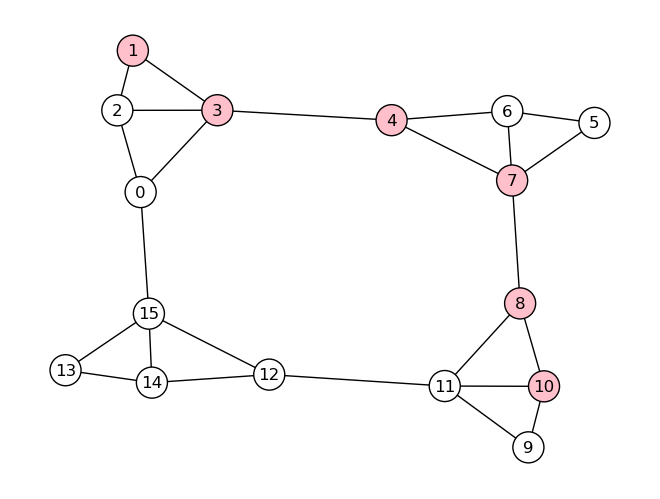

In [13]:
# générer un graphe
G = nx.connected_caveman_graph(4, 4)

# calcul des prédécesseurs depuis le sommet 1
predecesseurs = parcours_largeur(G, 1, afficher=False)

# calculer le chemin entre les sommets 1 et 10
chemin_court = chemin(predecesseurs, 1, 10)
print(chemin_court)

# afficher le chemin
afficher_graphe(G, couleurs={s: "pink" if s in chemin_court else "white" for s in G.nodes()})

**Question.** Rassembler la fonction `parcours_largeur` et la fonction `chemin` afin de définir une fonction `plus_court_chemin` qui prend en argument un graphe et deux sommets, et retourne le plus court chemin entre les deux dans le graphe.

Vérifiez que vous retrouvez bien le chemin que vous obteniez à la question précédente.

In [14]:
def plus_court_chemin(G, s, v):
    return chemin(parcours_largeur(G, s),s,  v)

## Labyrinthe

On peut dès lors coder une fonction qui recherche un chemin dans un labyrinthe !

Voilà une fonction qui génère un labyrinthe et une fonction qui l'affiche.
Le labyrinthe est représenté en mémoire comme un graphe, où les sommets sont les cases du labyrinthe, et où il y a une arête entre deux sommets s'il est possible d'aller d'une case à une autre.

On verra bientôt comment on peut utiliser des algorithmes de graphes pour générer des labyrinthes. :)


La fonction `labyrinthe` renvoie un graphe qui correspond à la structure de labyrinthe décrite ci-dessus. Elle prend en argument la dimension du labyrinthe que l'on souhaite générer (par défaut 10 par 10 cases).

La fonction `afficher_labyrinthe` permet d'afficher un labyrinthe, et l'on peut passer une liste de sommets (un chemin donc !) avec l'argument `solution` pour l'afficher.

In [15]:
from matplotlib.collections import LineCollection

# generateur de labyrinthe
def labyrinthe(dimension=(10, 10)):
    # générer une grille
    G = nx.grid_graph(dimension)

    # donner des poids aléatoires aux arêtes
    weights = {(u, v): np.random.random() for u in G.nodes() for v in G.nodes()}
    nx.set_edge_attributes(G, values=weights, name='weight')

    # calculer un arbre couvrant de poids maximal
    return nx.maximum_spanning_tree(G, algorithm="kruskal")

# affichage du labyrinthe
def afficher_labyrinthe(lab, solution=None, explored=None, frontiere=None, courant=None):
    pos = {u: u for u in lab.nodes()}
    width, height = (1 + list(lab.nodes())[-1][0], 1 + list(lab.nodes())[-1][1]) 
    
    plt.figure(figsize=(width, height))
    lines = [[(-0.5, -0.5), (width - 0.5, - 0.5)],
             [(-0.5, -0.5), (- 0.5, height - 0.5)],
             [(width - 0.5, -0.5), (width - 0.5, height - 0.5)],
             [(-0.5, height - 0.5), (width - 0.5, height - 0.5)]]
    
    for i in range(width):
        for j in range(height):
            if ((i, j), (i, j+1)) not in lab.edges():
                lines.append([(i - 0.5, j + 0.5), (i + 0.5, j + 0.5)])
            if ((i, j), (i+1, j)) not in lab.edges():
                lines.append([(i + 0.5, j - 0.5), (i + 0.5, j + 0.5)])
    
    if solution is not None:
        solx = [u for (u, v) in solution]
        soly = [v for (u, v) in solution]
        plt.plot(solx, soly, color="red")
        
    if explored is not None:
        explx = [u for (u, v) in explored]
        exply = [v for (u, v) in explored]
        plt.scatter(explx, exply)
    
    if frontiere is not None:
        fx = [v[0] for (u, v) in frontiere]
        fy = [v[1] for (u, v) in frontiere]
        plt.scatter(fx, fy, color="green")
        
    if courant is not None:
        plt.scatter(courant[0], courant[1], color="yellow")

    plt.xlim(-0.5, width-0.5)
    plt.ylim(-0.5, height-0.5)
    plt.gca().add_collection(LineCollection(lines, colors="black"))
    plt.axis("off")

On peut afficher un exemple de labyrinthe :

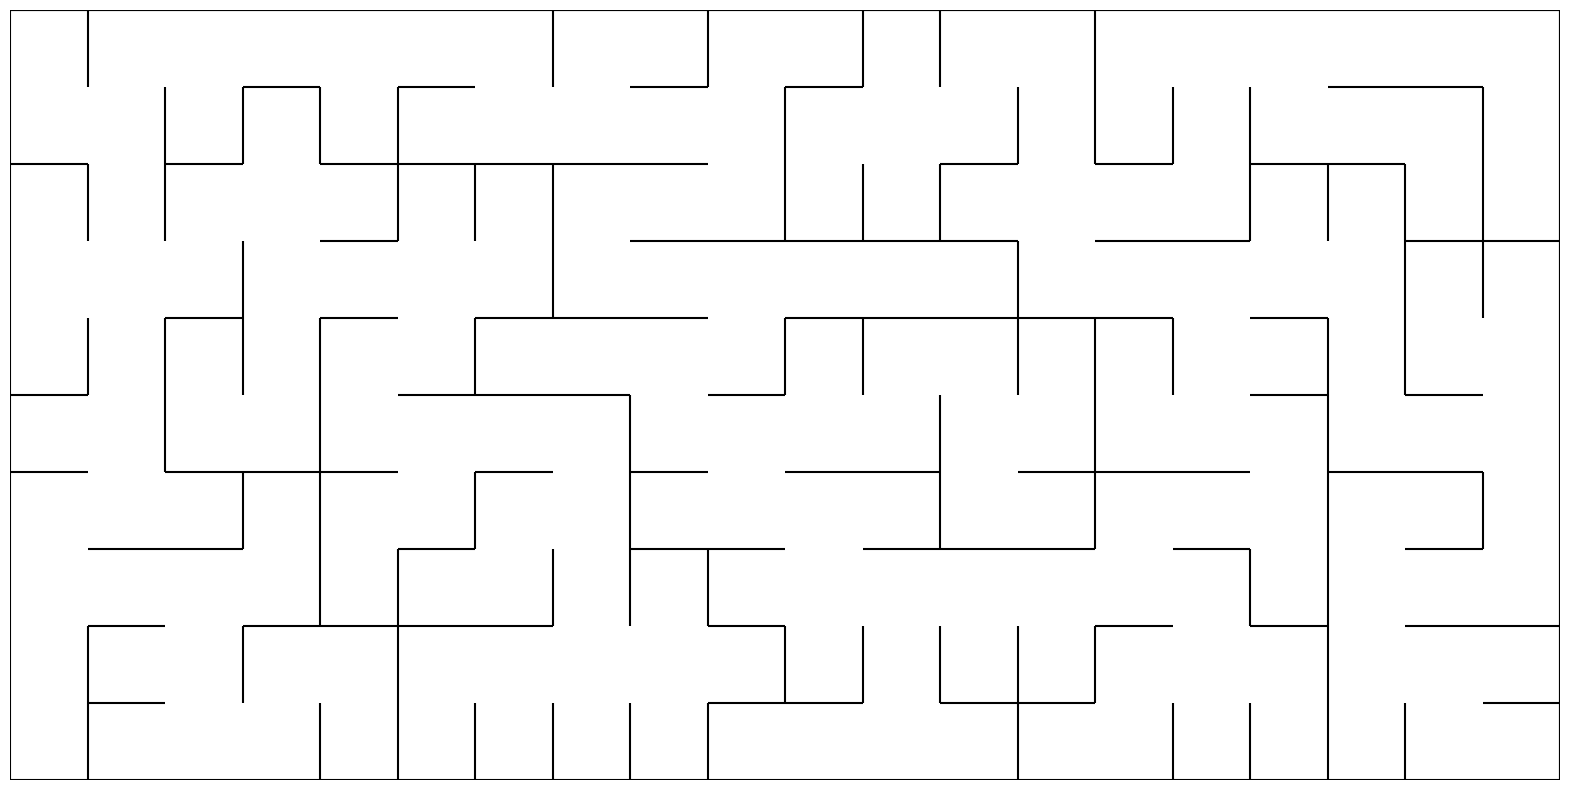

In [16]:
lab = labyrinthe((10, 20))
afficher_labyrinthe(lab)

**Question.** Utilisez la fonction de recherche de chemin que vous avez implémentée plus haut pour trouver un chemin dans ce labyrinthe. On partira de la case $(10, 5)$ pour arriver à la case opposée.

In [17]:
solution = plus_court_chemin(lab, (10,5), (0,0))

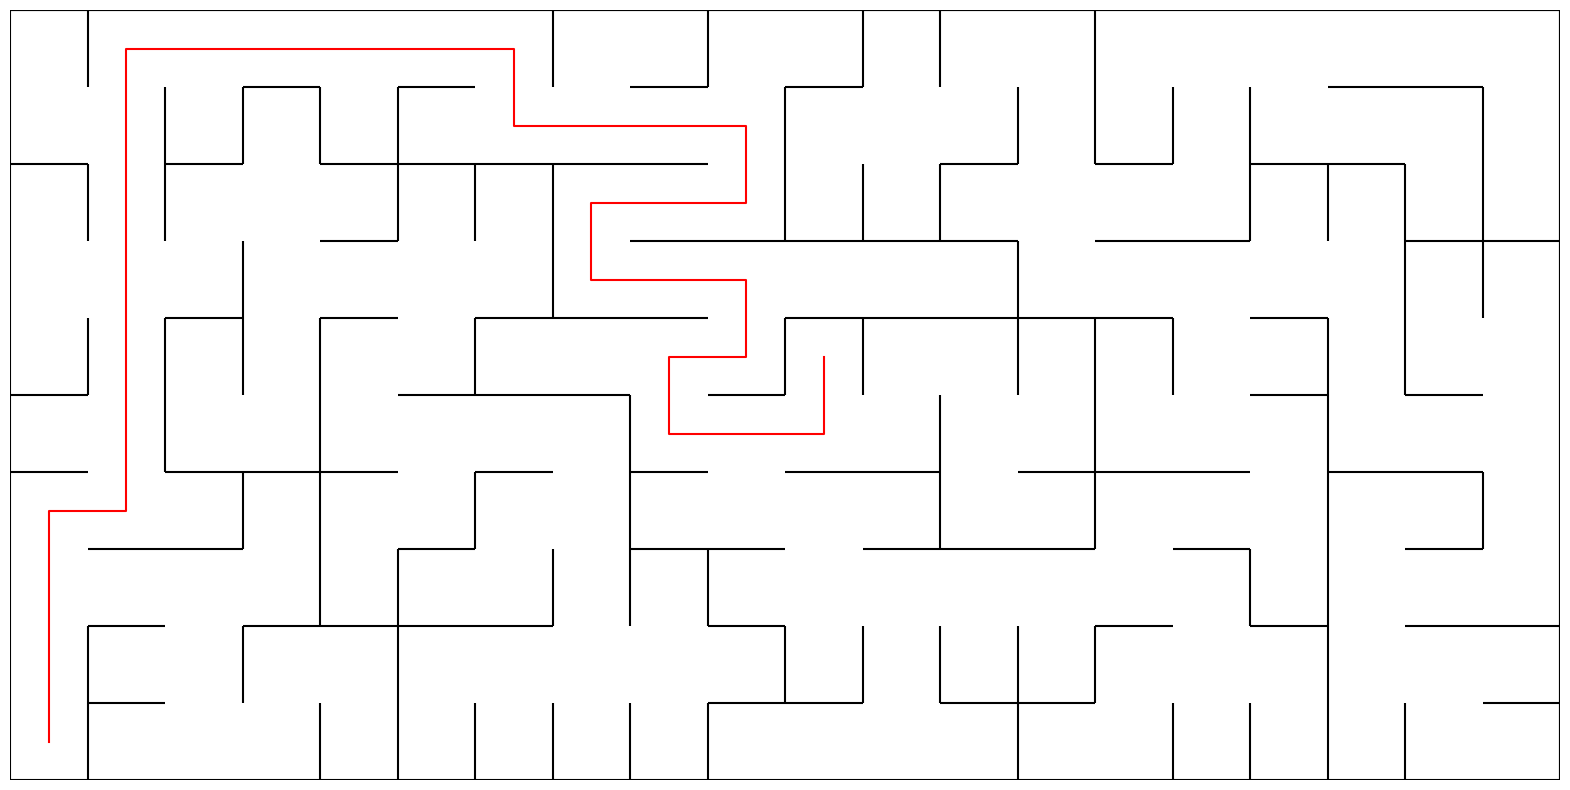

In [18]:
afficher_labyrinthe(lab, solution)

## Un algorithme plus efficace

Pour l'instant, notre algorithme de recherche de chemin parcourt tout le graphe pour trouver un chemin.

Il n'est pas possible de trouver un meilleur algorithme, car dans le pire cas, on va devoir parcourir l'ensemble des sommets et des arêtes du graphe pour trouver une solution.

En revanche, dans bien des cas, il y a vraiment beaucoup de chemins qui ne mènent à rien... par exemple, dans notre labyrinthe, à chaque branchement, un seul mène à la sortie, alors que les autres mènent à un cul de sac.

On ne peut pas savoir a priori quel chemin est le bon, mais on peut se dire que, si le chemin nous fait revenir vers la gauche ou vers le bas, alors on a plus de chances de s'éloigner de la sortie.
Ce type de raisonnement s'appelle un raisonnement **heuristique** : on sait que ce n'est pas toujours vrai, mais on se dit qu'on a plus de chances de trouver une solution en tournant dans une direction que l'on pense nous rapprocher de la sortie.

C'est le principe de l'algorithme A*, qui est extrêmement utilisé dans les jeux vidéos, pour définir le déplacement des personnages autour d'obstacles : au lieu de tout chercher, on cherche en priorité les chemins qui devraient nous rapprocher.

**Heuristique.** Comme heuristique, on utilisera la distance à vol d'oiseau entre le sommet courant et le sommet que l'on cherche à rejoindre :

In [19]:
def heuristique(s, v):
    return np.linalg.norm(np.array(s) - np.array(v))

heuristique((10,5), (10,10))

5.0

**Structure de données.** Dans l'algorithme de parcours en largeur étudié plus haut, on explorait le graphe, puis on décidait quel était le prochain sommet à visiter en prenant le sommet que l'on avait rencontré le plus tôt.
On utilisait donc naturellement une structure de file : le premier élément exploré était le premier à être visité.

Ici, au lieu de visiter les sommets dans l'ordre où on les rencontre, on visite le sommet que l'on pense être le plus proche de la sortie du labyrinthe.

On va donc utiliser une **file de priorité**, qui garde en mémoire des tuples de la forme `(valeur, élément)`.
Elle fonctionne ensuite comme une file classique, sauf qu'au lieu de renvoyer le premier élément qui y a été ajouté, elle renvoie l'élément dont la *valeur* est la plus faible.

En Python, on peut utiliser le module [heapq](https://docs.python.org/fr/3/library/heapq.html) qui permet de faire ces opérations dans une liste. 

In [20]:
import heapq

In [21]:
q = []

heapq.heappush(q, (10, 'a'))
heapq.heappush(q, (5, 'b'))
heapq.heappush(q, (50, 'c'))

resultat = heapq.heappop(q)

print("Couple (valeur, élément) :", resultat)

resultat = heapq.heappushpop(q,(25,'d'))

print("Couple (valeur, élément) :", resultat)

# pour avoir l'élément lui-même, il faut regarder resultat[1]:
print("Élément :", resultat[1])

Couple (valeur, élément) : (5, 'b')
Couple (valeur, élément) : (10, 'a')
Élément : a


In [22]:
q

[(25, 'd'), (50, 'c')]

### Algorithme A*

L'algorithme est très similaire à l'algorithme de parcours en largeur, sauf qu'à la place des sommets visités, on va garder en mémoire la distance entre le sommet de départ et les autres sommets, calculée au fur et à mesure.

À noter qu'un sommet dont la distance a été calculée est donc un sommet qui a été visité.

On a donc en mémoire :
* une file de priorité `a_visiter` qui correspond aux éléments que l'on a repérés mais pas encore visités ;
* un dictionnaire `predecesseur` qui indique, pour chaque sommet, quel sommet y a mené dans le parcours (cela va permettre de trouver le plus court chemin) ;
* un dictionnaire `distance`, qui contient, pour chaque sommet, la distance du chemin que l'on a calculé jusqu'à lui pour l'instant.

Au début, `a_visiter` contient seulement `(0, sommet_de_départ)`, et `distances` est initialisé de façon à ce que pour tous les sommets `s` du graphe, `distance[s] = np.inf`, sauf le sommet de départ qui vaut `distance[sommet_de_départ] = 0`.

L'algorithme consiste alors à itérer ainsi :

Tant que `a_visiter` n'est pas vide :
* tirer `s` dans la file de priorité (c'est celui qui est censé être le plus proche de la sortie selon notre heuristique) ;
* si `s` est la sortie (le sommet que l'on cherche à atteindre), renvoyer le chemin qui y mène (grâce à la liste prédecesseurs) ;
* sinon, pour chaque sommet voisin `v` de `s` (donc dans `adj(s)`) :
    * si `distance[s] + 1 < distance[v]` (soit on n'a jamais rencontré ce sommet, soit on a trouvé un chemin plus court) :
        * mettre à jour `distance[v] = distance[s] + 1` ;
        * `predecesseur[v] = s` ;
        * ajouter `(distance[v] + heuristique(v, sortie), v)` à `a_visiter`.

In [23]:
def Astar(G, sommet_de_départ, sortie, afficher=False):
    a_visiter = []
    heapq.heappush(a_visiter, (0, sommet_de_départ))
    distance = {sommet_de_départ : 0}
    for sommet in G:
        distance[sommet] = np.inf
    predecesseur = {sommet_de_départ: None}
    adj = liste_adjacence(G)
    while len(a_visiter) != 0:
        s = heapq.heappop(a_visiter)[1]
        if s == sortie:
            print('res')
            solution = chemin(predecesseur,sommet_de_départ, sortie)
            if afficher:
                afficher_labyrinthe(G, solution)
            return solution
        for v in adj[s]:
            if (distance[s] + 1) < distance[v]:
                distance[v] = distance[s] + 1
                predecesseur[v] = s
                heapq.heappush(a_visiter, (distance[v] + heuristique(v, sortie), v))


**Question** Vérifiez que vous retrouvez bien le même chemin pour aller au bout du labyrinthe. Affichez le labyrinthe. Vous pouvez aussi afficher les cases explorées.

In [24]:
lab = labyrinthe((20, 20))

In [25]:
solution = Astar(lab, (10,5), (0,0), True)

**Question** On peut comparer le temps d'exécution sur un labyrinthe assez grand.

In [ ]:
grand_lab = labyrinthe((40, 40))

**Question.** Commenter cette différence de temps d'exécution.

*Réponse*